# Intro to Machine Learning: Lesson 2

## Deep dive into Random Forests

In [1]:
%matplotlib inline

In [168]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

Load data

In [169]:
PATH = "data/bulldozers/"
df_raw = pd.read_csv(f"{PATH}Train.csv", low_memory=False, parse_dates=["saledate"])

Replace price with log price due to Kaggle scoring.

In [170]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

Add date features

In [171]:
add_datepart(df_raw, "saledate")

Replace string columns with categories.

In [172]:
train_cats(df_raw)

Reorder some categories.

In [173]:
df_raw.UsageBand.cat.set_categories(
    ["High", "Medium", "Low"],
    ordered=True, inplace=True)

df_raw.ProductSize.cat.set_categories(
    ['Large', 'Large / Medium', 'Medium', 'Compact', 'Small', 'Mini'],
    ordered=True, inplace=True)

df_raw.Grouser_Type.cat.set_categories(
    ['Single', 'Double', 'Triple'],
    ordered=True, inplace=True)

Split into two input/output. Replace nas with their median.

In [174]:
df, y, nas = proc_df(df_raw, "SalePrice")

Split into training and validation sets.

In [175]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_train = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((389125, 66), (389125,), (12000, 66), (12000,))

In [107]:
def rmse(y1, y2):
    return np.sqrt(np.mean((y1 - y2)**2))

def print_scores(m):
    print("rmse(train/val): {:.3}/{:.3}, r2(train/val): {:.3}/{:.3}".format(
        rmse(m.predict(X_train), y_train),
        rmse(m.predict(X_valid), y_valid),
        m.score(X_train, y_train),
        m.score(X_valid, y_valid)))

model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
%time model.fit(X_train, y_train)
          
print_scores(model)

CPU times: user 11min 12s, sys: 2.87 s, total: 11min 15s
Wall time: 1min 32s
rmse(train/val): 0.0762/0.232, r2(train/val): 0.988/0.904


Results for 100 trees using all features:
```
CPU times: user 15min 27s, sys: 3.52 s, total: 15min 30s
Wall time: 2min 8s
rmse(train/val): 0.0757/0.234, r2(train/val): 0.988/0.902
```

Results for 100 trees using best 26 features:
```
CPU times: user 11min 12s, sys: 2.87 s, total: 11min 15s
Wall time: 1min 32s
rmse(train/val): 0.0762/0.232, r2(train/val): 0.988/0.904
```

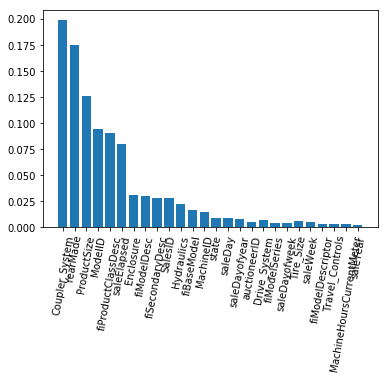

In [133]:
model.feature_importances_, X_train.columns
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation=80)
plt.show()

### Reduce training set to speed things up

In [176]:
X_train.shape

(389125, 66)

In [177]:
N = 30000
subset = np.random.permutation(range(X_train.shape[0]))[:N]
X_train_some = X_train.copy().loc[subset,:]
y_train_some = y_train.copy()[subset]

In [254]:
X_train_some.shape, y_train_some.shape, X_train.shape, y_train.shape

((30000, 66), (30000,), (389125, 66), (389125,))

In [253]:
X_valid.shape, y_valid.shape

((12000, 66), (12000,))

## Small tree

rmse(train/val): 0.536/0.524, r2(train/val): 0.399/0.509


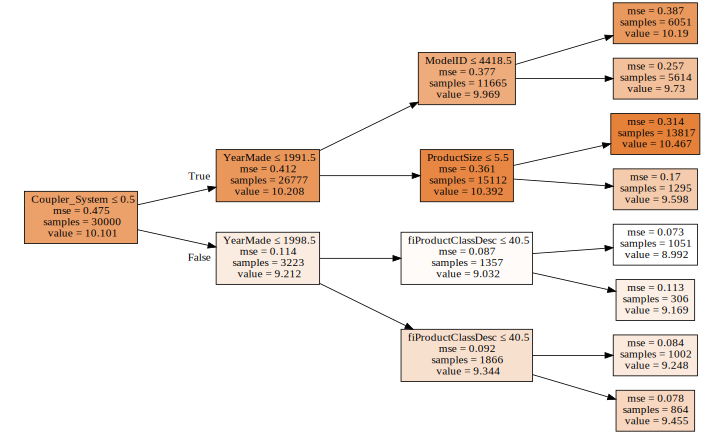

In [181]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train_some, y_train_some)
print_scores(m)
draw_tree(m.estimators_[0], X_train_some, precision=3)

# Big tree

rmse(train/val): 0.421/0.422, r2(train/val): 0.629/0.682


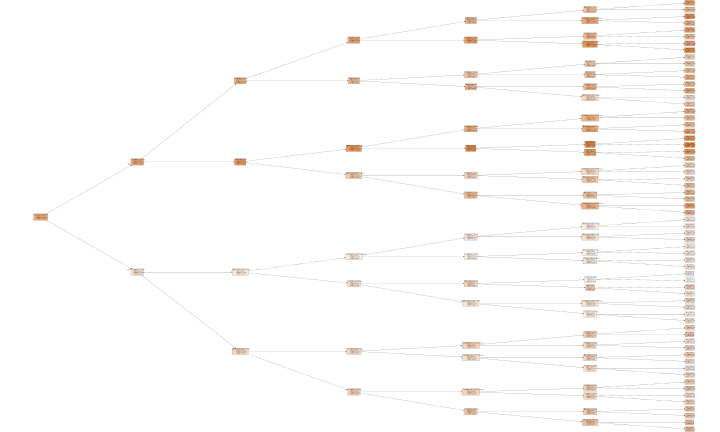

In [186]:
m = RandomForestRegressor(n_estimators=1, max_depth=6, bootstrap=False, n_jobs=-1)
m.fit(X_train_some, y_train_some)
print_scores(m)
draw_tree(m.estimators_[0], X_train_some, precision=3)

In [188]:
m = RandomForestRegressor(n_estimators=1,  bootstrap=False, n_jobs=-1)
m.fit(X_train_some, y_train_some)
print_scores(m)

rmse(train/val): 0.346/0.433, r2(train/val): 0.75/0.665


# Bagging

In [241]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=45)
m.fit(X_train_some, y_train_some)
print_scores(m)

rmse(train/val): 0.245/0.281, r2(train/val): 0.875/0.859


### Correlation between trees in RandomForestRegressor

Number of trees.

In [237]:
tree_predictions = np.stack([tree.predict(X_train_some) for tree in m.estimators_])

In [238]:
correlation_matrix = np.corrcoef(tree_predictions)
np.mean(correlation_matrix, axis=1)

array([0.90789, 0.90975, 0.90979, 0.90911, 0.90818, 0.90806, 0.90659, 0.90798, 0.90796, 0.91019, 0.90969,
       0.90948, 0.90673, 0.90991, 0.9091 , 0.90791, 0.90903, 0.91014, 0.90824, 0.9087 , 0.90753, 0.90892,
       0.90921, 0.9079 , 0.90746, 0.90799, 0.9091 , 0.90711, 0.90617, 0.90902, 0.91053, 0.91007, 0.90741,
       0.90966, 0.90904])

We see that the correlation between the trees is "only" around 0.9. Which is a lot better than 1!

## R^2 for each tree vs the entire forest

In [234]:
[print_scores(tree) for tree in m.estimators_[0:5]]

rmse(train/val): 0.374/0.464, r2(train/val): 0.708/0.615
rmse(train/val): 0.372/0.44, r2(train/val): 0.711/0.654
rmse(train/val): 0.366/0.419, r2(train/val): 0.721/0.686
rmse(train/val): 0.363/0.414, r2(train/val): 0.725/0.694
rmse(train/val): 0.367/0.433, r2(train/val): 0.719/0.666


[None, None, None, None, None]

Example output (takes a long time):
```
rmse(train/val): 0.374/0.464, r2(train/val): 0.708/0.615
rmse(train/val): 0.372/0.44, r2(train/val): 0.711/0.654
rmse(train/val): 0.366/0.419, r2(train/val): 0.721/0.686
rmse(train/val): 0.363/0.414, r2(train/val): 0.725/0.694
rmse(train/val): 0.367/0.433, r2(train/val): 0.719/0.666
rmse(train/val): 0.372/0.422, r2(train/val): 0.712/0.682
rmse(train/val): 0.371/0.421, r2(train/val): 0.713/0.684
rmse(train/val): 0.372/0.411, r2(train/val): 0.71/0.699
rmse(train/val): 0.372/0.41, r2(train/val): 0.711/0.699
rmse(train/val): 0.368/0.41, r2(train/val): 0.717/0.699
rmse(train/val): 0.367/0.408, r2(train/val): 0.719/0.703
rmse(train/val): 0.378/0.495, r2(train/val): 0.702/0.562
rmse(train/val): 0.373/0.411, r2(train/val): 0.71/0.698
rmse(train/val): 0.375/0.413, r2(train/val): 0.707/0.695
rmse(train/val): 0.368/0.423, r2(train/val): 0.716/0.68
rmse(train/val): 0.372/0.415, r2(train/val): 0.71/0.692
rmse(train/val): 0.378/0.423, r2(train/val): 0.702/0.68
rmse(train/val): 0.372/0.457, r2(train/val): 0.711/0.626
rmse(train/val): 0.373/0.43, r2(train/val): 0.71/0.669
rmse(train/val): 0.37/0.408, r2(train/val): 0.714/0.702
rmse(train/val): 0.374/0.41, r2(train/val): 0.708/0.699
```

The interesting part is that each tree has a lot worse score than the forest has.
The whole is better.

## Improving r^2 by using more and more trees

In [242]:
preds = np.stack([tree.predict(X_valid) for tree in m.estimators_])
preds.shape

(45, 12000)

0.8200896547508346


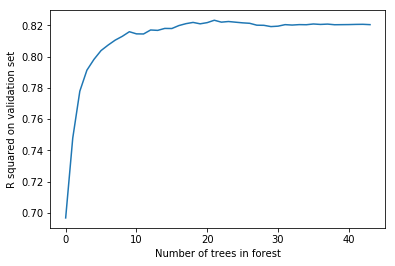

In [246]:
plt.plot([metrics.r2_score(np.mean(preds[:i,:], axis=0), y_valid) for i in range(1, m.n_estimators)])
print(metrics.r2_score(np.mean(preds, axis=0), y_valid))
plt.ylabel("R squared on validation set")
plt.xlabel("Number of trees in forest")
plt.show()

More trees are better, but at some point we stop improving.

In [244]:
metrics.r2_score(m.predict(X_valid), y_valid)

0.8200896547508346

Choosing **n_estimators**: As many as possible for finalizing model overnight (e.g. 1000). For getting insights and feature engineering, you can use 20-30.

Also we see that the RandomForestRegressor simply uses the mean of every estimator in the tree. Nothing more complicated than that.

Protip from Jeremy: Use a smaller number of samples per tree in RandomForestRegressor for a huge performance boost during exploration phase.

Using the set_rf_samples() function.

In [261]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [250]:
set_rf_samples(20000)
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
m.fit(X_train, y_train)
print_scores(m)

rmse(train/val): 0.227/0.264, r2(train/val): 0.892/0.876


Improve performance with min_samples_leaf.

In [262]:
set_rf_samples(20000)
m = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_features=0.5, min_samples_leaf=3, oob_score=True)
m.fit(X_train, y_train)
print_scores(m)

rmse(train/val): 0.23/0.26, r2(train/val): 0.889/0.879


`max_features` choose a random subset of all features for each tree.

## ExtraTreesRegressor

In [207]:
from sklearn.ensemble import ExtraTreesRegressor
m = ExtraTreesRegressor(n_jobs=-1, n_estimators=100)
m.fit(X_train_some, y_train_some)
print_scores(m)

rmse(train/val): 0.242/0.281, r2(train/val): 0.877/0.859


In [248]:
??set_rf_samples